In [ ]:
%matplotlib inline

In [134]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib.widgets import Slider, Button, RadioButtons
from pylab import cm
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter
import datetime 

############################################################################
#                          CONVERSIONS  
############################################################################

def mm_to_in(var):
    """
    Sums precipitation fields in mm and converts to inches
    Requires:
        vars => list of precipitation variables in mm
    Returns:
        sum of all components of vars in inches
    """
    return np.array(var) * 0.03937

def ms_to_kts_barb(U, V):
    """
    Converts wrfout u and v winds in meters/second to knots 
    """
    return U*1.94384, V*1.94384

def ms_to_kts(WIND):
    """
    Converts wrfout wind speeds in meters/second to knots 
    """
    return WIND*1.94384

def olr_to_temp(OLR):
    """
    Converts OLR to radiating temperature in Celisus
    by the Stefan-Boltzmann law
    Requires:
        OLR => Outgoing longwave radiation (W/m^2)
    Returns:
        temperature in Celsius
    """
    return np.power(OLR / 5.67E-8, 0.25) - 273.
 
def K_to_F(TEMP):
    """
    Given temperature in Kelvin, return in Fahrenheit
    Requires:
        TEMP =>  Temperature (K)
    Returns:
        Temperature in Fahrenheit
    """
    return (TEMP - 273.) * 9./5. + 32.

class WRFobject:
    """ Pass in WRF filepath to plot 2d and 3d data fields """
    def __init__(self,filepath):
        self.filepath = filepath
        self.wrf = nc.Dataset(filepath)
        self.lons = self.wrf.variables['XLONG'][0]
        self.lats = self.wrf.variables['XLAT'][0]
        self.lat0 = self.wrf.CEN_LAT
        self.lon0 = self.wrf.CEN_LON
        self.lat1 = self.wrf.TRUELAT1
        self.lat2 = self.wrf.TRUELAT2
        self.gp_width = len(self.wrf.dimensions['west_east'])
        self.gp_height = len(self.wrf.dimensions['south_north'])
        self.dx = self.wrf.DX
        self.dy = self.wrf.DY
        self.high = self.dy*(self.gp_height-1)
        self.wide = self.dx*(self.gp_width-1)
        self.times = self.wrf.variables['T'].shape[0]
        self.m = self.make_basemap()
        self.x,self.y = self.make_xy(self.m)
#        self.save_base = '/Users/severe/Research/plots/'
#        self.datestring = filepath[-19:-15]+filepath[-14:-12]+filepath[-11:-9]+filepath[-8:-6]
        self.save_base = './plots/'
        self.datestring = '20110522'
        self.start_date = datetime.datetime.strptime(self.wrf.START_DATE,"%Y-%m-%d_%H:%M:%S")
        self.all_times = self.wrf.variables['Times']

############################################################################
#                          PLOTTING  
############################################################################

    def make_basemap(self):
        """ make basemap figure """
        return Basemap(projection='lcc',width=self.wide,height=self.high,resolution='i',
            lat_0=self.lat0,lon_0=self.lon0,lat_1=self.lat1,lat_2=self.lat2)

    def make_xy(self,m):
        return m(self.lons,self.lats)

    def make_plot(self,data,title,save_string,units,t,
                  c_range=[None],
                  other_plots=[False,False],
                  wind_data=[0,0],
                  c_table=cm.spectral,
                  savefig=False):
        """ Make a figure plot given the input variables:
        Required:
         data: numpy array of data to be plotted
         title: Title to place on figure
         save_string: Filename to save figure to if save keyword is turned on. Saves to /plots in current directory
         units: units of data
         t: time of plotting
        Keyword Args:
         c_range: contour range for plotting data
         other_plots: list of other items to plot (i.e. wind barbs or slp contours)
         wind_data: if other_plots has input in first index (i.e. wind), use wind_data to input the u,v wind data
         c_table: color table to plot data
        """
        if c_range is None:
            c_range = np.arange(np.min(data),np.max(data),(np.max(data)-np.min(data))/20.)
        plt.figure(figsize=[10,6])
        self.m.drawcoastlines()
        self.m.drawcountries()
        self.m.drawstates()
        self.m.drawparallels(np.arange(0,90,5),labels=[1,0,0,0],fontsize=10)
        self.m.drawmeridians(np.arange(-180,0,5),labels=[0,0,0,1],fontsize=10)
        cs = plt.contourf(self.x,self.y,data[0],c_range,cmap=c_table)
        cbar = plt.colorbar(cs,orientation='vertical',shrink=0.875,pad=0.02)
        if other_plots[0]: # plot wind
            self.x_wind,self.y_wind = self.m(self.lons[::20,::20],self.lats[::20,::20])            
            plt.barbs(self.x_wind,self.y_wind,wind_data[0][::20,::20],wind_data[1][::20,::20],
                length=5,pivot='middle')
        if other_plots[1]:  # plot SLP contour
            LEVS_slp = range(990,1020,2)
            cs = plt.contour(self.x,self.y,ndimage.gaussian_filter(data[1],sigma=1.0,order=0),
                LEVS_slp,colors='k',linestyles='solid')
            plt.clabel(cs,inline=1,fontsize=10,fmt='%4.0f')
        plt.title("{0} ({1})".format(title,units),loc='left',fontsize=8)
        plt.title(" Init: {0} \nValid: {1}".format(''.join(self.wrf.variables['Times'][0]),''.join(self.wrf.variables['Times'][t])),loc='right',fontsize=8,horizontalalignment='right')
        if savefig:
            plt.savefig("{0}{1}_fhr{2}_{3}.png".format(self.save_base,save_string,"%02d"%t,self.datestring),
                        bbox_inches='tight',
                        format='PNG',
                        dpi=300)
    
    def make_plot_ul(self,data,title,save_string,units,t,
                     c_range=[None],
                     other_plots=[False,False],
                     wind_data=[0,0],
                     c_table=cm.spectral,
                     savefig=False):
        """ Make a figure plot of an upper-level variable given the input variables:
        Required: 
            data: numpy array of data to be plotted
            title: Title to place on figure
            save_string: Filename to save figure to if save keyword is turned on. Saves to /plots in current directory
            units: units of data
            t: time of plotting
        Keyword Args:
            c_range: contour range for plotting data
            other_plots: list of other items to plot (i.e. wind barbs or slp contours)
            wind_data: if other_plots has input in first index (i.e. wind), use wind_data to input the u,v wind data
            c_table: color table to plot data
        """
        if c_range is None:
            c_range = np.arange(np.min(data),np.max(data),(np.max(data)-np.min(data))/20.)
        plt.figure(figsize=[10,6])
        self.m.drawcoastlines()
        self.m.drawcountries()
        self.m.drawstates()
        self.m.drawparallels(np.arange(0,90,5),labels=[1,0,0,0],fontsize=10)
        self.m.drawmeridians(np.arange(-180,0,5),labels=[0,0,0,1],fontsize=10)
        cs = plt.contourf(self.x,self.y,data[0],c_range,cmap=c_table)
        cbar = plt.colorbar(cs,orientation='vertical',shrink=0.875,pad=0.02)
        if other_plots[0]: # plot wind
            self.x_wind,self.y_wind = self.m(self.lons[::20,::20],self.lats[::20,::20])            
            plt.barbs(self.x_wind,self.y_wind,wind_data[0][::20,::20],wind_data[1][::20,::20],
                length=5,pivot='middle')
        if other_plots[1]:  # plot temp contour
            LEVS_slp = range(990,1020,2)
            cs = plt.contour(self.x,self.y,ndimage.gaussian_filter(data[1],sigma=1.0,order=0),
                LEVS_slp,colors='k',linestyles='solid')
            plt.clabel(cs,inline=1,fontsize=10,fmt='%4.0f')
        plt.title("{0} ({1})".format(title,units),loc='left',fontsize=8)
        plt.title(" Init: {0} \nValid: {1}".format(''.join(self.wrf.variables['Times'][0]),''.join(self.wrf.variables['Times'][t])),loc='right',fontsize=8,horizontalalignment='right')
        if savefig:
            plt.savefig("{0}{1}_fhr{2}_{3}.png".format(self.save_base,save_string,"%02d"%t,self.datestring),
                        bbox_inches='tight',
                        format='PNG',
                        dpi=300)

    def plot_var(self,var,time,threeD=False,lev=0):
        """ plot variables at specific time (input) and level (input) if 3D. Levels are given 
        as model levels, not in another unit (e.g. pressure, height, etc.) """
        plt.figure(figsize=[10,6])
        self.m.drawcoastlines()
        self.m.drawcountries()
        self.m.drawstates()
        if threeD:
            D=plt.contourf(self.x,self.y,self.grab_variable(var)[time,lev,:,:],cmap=matplotlib.cm.spectral)
        else:
            D=plt.contourf(self.x,self.y,self.grab_variable(var)[time,:,:],cmap=matplotlib.cm.spectral)
        plt.colorbar()
        plt.show() 

############################################################################
#               INTERPOLATION AND NETCDF VARIABLE READING  
############################################################################        
        
    def grab_variable(self,var):
        """ grab variable of interest
        type: ncdump -h wrfile.nc into command line for variable options """
        return self.wrf.variables[var]
    
    def plev_interp(self,VAR, time=0,plev=500.):
        """
        Function to interpolate arbitrary 3d variable
        to a given pressure level
    
        If the field is below the ground level or
        off the model top, will return np.nan there
        Requires:
            VAR => Arbitrary 3d variable
            plev => pressure level to interpolate to (hPa, float)
        Returns:
            2d array of "var" interpolated to desired pressure level
        """
        P = self.grab_variable('P')[time]
        PB = self.grab_variable('PB')[time]
        # Total pressure
        ptot  = PB + P
    
        # Approximate the height of the given plev
        # By finding the index in the z dimension we first
        # cross it in each column
        above = np.argmax(ptot < plev*100., axis=0)
        # Get the index below that too
        below = above - 1
        # If we are below ground, set to zero
        below[below < 0] = 0

        nz,ny,nx = ptot.shape
        # Get the P values at these two above and below levels
        aboveP = np.log(ptot.reshape(nz,ny*nx)[above.flatten(),xrange(ny*nx)].reshape(ny,nx))
        belowP = np.log(ptot.reshape(nz,ny*nx)[below.flatten(),xrange(ny*nx)].reshape(ny,nx))
        # For a linear interpolation, weight by distance from plev
        distAbove = np.abs(aboveP - np.log(plev*100))
        distBelow = np.abs(belowP - np.log(plev*100))
        total_dist = distAbove + distBelow
        weightAbove = 1.0 - (distAbove/total_dist)
        weightBelow = 1.0 - weightAbove
   
        # Now grab var at these two levels, weight with our
        # calculated weights, and add to get interpolated value
        nz,ny,nx = VAR.shape
        varflat = VAR.reshape(nz, ny*nx)
        aboveV = varflat[above.flatten(),xrange(ny*nx)].reshape(ny,nx)
        belowV = varflat[below.flatten(),xrange(ny*nx)].reshape(ny,nx)
        final = aboveV * weightAbove + belowV * weightBelow
        # Anywhere we were below ground or above model top is np.nan
        final[above==0] = np.nan

        # Optionally, to verify that the interpolation works, uncomment
        # the following two lines which will print the average pressure
        # level from the interpolation as compared to what was requested
        #finalP = aboveP * weightAbove + belowP * weightBelow
        #print(" Requested P:", plev*100., "Mean Interp. P:", np.nanmean(np.exp(finalP)))    
    
        return final

    def hgt_interp(self,VAR,time=0,hgt=6.):
        """
        Function to interpolate arbitrary 3d variable
        to a given height
    
        If the field is below the ground level or
        off the model top, will return np.nan there
        Requires:
            VAR => Arbitrary 3d variable
            hgt => height level to interpolate to (km, float)
        Returns:
            2d array of "var" interpolated to desired height 
        """
        PH = self.grab_variable('PH')[time]
        PHB = self.grab_variable('PHB')[time]
        #VAR = self.grab_variable(var)[time]
        # Total pressure
        hgts_asl  = ((PH[:-1]+PH[1:])/2 + (PHB[:-1]+PHB[1:])/2)/9.81
        hgts_agl = hgts_asl[:] - self.grab_variable('HGT')[time]
        # Approximate the height of the given plev
        # By finding the index in the z dimension we first
        # cross it in each column
        above = np.argmin(hgts_agl < hgt*1000., axis=0)
        # Get the index below that too
        below = above - 1
        # If we are below ground, set to zero
        below[below < 0] = 0
        
        nz,ny,nx = hgts_agl.shape
        # Get the P values at these two above and below levels
        aboveH = hgts_agl.reshape(nz,ny*nx)[above.flatten(),xrange(ny*nx)].reshape(ny,nx)
        belowH = hgts_agl.reshape(nz,ny*nx)[below.flatten(),xrange(ny*nx)].reshape(ny,nx)
        # For a linear interpolation, weight by distance from plev
        distAbove = np.abs(aboveH - hgt*1000.)
        distBelow = np.abs(belowH - hgt*1000.)
        total_dist = distAbove + distBelow
        weightAbove = 1.0 - (distAbove/total_dist)
        weightBelow = 1.0 - weightAbove
   
        # Now grab var at these two levels, weight with our
        # calculated weights, and add to get interpolated value
        nz,ny,nx = VAR.shape
        varflat = VAR.reshape(nz, ny*nx)
        aboveV = varflat[above.flatten(),xrange(ny*nx)].reshape(ny,nx)
        belowV = varflat[below.flatten(),xrange(ny*nx)].reshape(ny,nx)
        final = aboveV * weightAbove + belowV * weightBelow
        # Anywhere we were below ground or above model top is np.nan
        final[above==0] = np.nan

#        # Optionally, to verify that the interpolation works, uncomment
#        # the following two lines which will print the average pressure
#        # level from the interpolation as compared to what was requested
#        #finalP = aboveP * weightAbove + belowP * weightBelow
#        #print(" Requested P:", plev*100., "Mean Interp. P:", np.nanmean(np.exp(finalP)))    
    
        return final    
    
    
############################################################################
#                          VARIABLE CALCULATIONS  
############################################################################

    def slp(self,time=0):
        temps = self.grab_variable('T2')[time]
        psfc = self.grab_variable('PSFC')[time]
        stemps = temps+6.5*self.grab_variable('HGT')[time]/1000.
        mslp = psfc*np.exp(9.81/(287.0*stemps)*self.grab_variable('HGT')[time])*0.01
        return mslp

    def altimeter(self,time=0):
        """
        Compute altimeter setting
        Requires:
            PSFC => surface pressure (Pa, 2d)
            HGT => surface elevation (m, 2d)
        Returns:
            Smoothed altimeter setting field (hPa)
        """
        PSFC = self.grab_variables('PSFC')[time]
        HGT = self.grab_variable('HGT')[time]
        
        PSFC = PSFC / 100.
        alt = ((PSFC - 0.3) ** (0.190284) + 8.4228807E-5 * HGT) ** (1.0/0.190284)
        # Smooth this field
        return gaussian_filter(alt, sigma=6)
    
    def destagger_uv(self,u,v):
        """ Destagger U and V winds from WRF file """
        return 0.5*(u[:,:,:-1]+u[:,:,1:]),0.5*(v[:,:-1,:]+v[:,1:,:])
    
    def vorticity(self, time=0, plev=500.0):
        """
        Computes absolute vorticity from interpolations
        to specified pressure level
        
        Requires:
            U => u-wind component (m/s, 3d)
            V => v-wind component (m/s, 3d)
            XLAT => Latitudes (deg, 2d)
            PB => base-state pressure (Pa, 3d)
            P => perturbation pressure (Pa, 3d)
            plev => desired pressure level (hPa, float)
            dx => model grid spacing (m, float)
        Returns:
            absolute vorticity on pressure level (s^-1, 2d)
            Areas below ground will be np.nan
        """
        U = self.grab_variable('U')[time]
        V = self.grab_variable('V')[time]
        XLAT = self.grab_variable('XLAT')[time]
        PB = self.grab_variable('PB')[time]
        P = self.grab_variable('P')[time]
        
        
        # Unstagger winds
        u_unstaggered,v_unstaggered = self.destagger_uv(U,V)
        # Interpolate to pressure level
        u_interp = self.plev_interp(u_unstaggered, time=time, plev=plev)
        v_interp = self.plev_interp(v_unstaggered, time=time, plev=plev)
        # Compute coriolis component
        fc = 1.458E-4 * np.sin(XLAT*np.pi/180.)
        # Do our gradients
        dvdx = np.gradient(v_interp,self.dx,self.dx)[1]
        dudy = np.gradient(u_interp,self.dx,self.dx)[0]
        # Compute vorticity
        avort = dvdx - dudy + fc
        return avort
    
    def ultemp(self, time=0, plev=500.):
        T = self.grab_variable('T')[time]
        P = self.grab_variable('P')[time]
        PB = self.grab_variable('PB')[time]
        TBASE = self.grab_variable('T00')[time]
        temp = (TBASE + T) * ((PB+P)/100000.) ** (287./1004.)
        return self.plev_interp(temp,time=time,plev=plev) - 273.0 # in celcius
   
    def rh(self,time=0):
        """ Compute relative humidity near the surface, i.e. first model level """
        P = self.grab_variable('P')[time][0]
        PB = self.grab_variable('PB')[time][0]
        QVAPOR = self.grab_variable('QVAPOR')[time][0]
        T = self.grab_variable('T')[time][0]
        TBASE = self.grab_variable('T00')[time]

        
        # Get the temperature on the first level
        temp = (TBASE + T) * ((PB+P)/100000.) ** (287./1004.)
        # Back to Kelvin
        t = temp

        
        # Get the actual pressure in the interpolation
        # To take into account small errors
        #press_lev = self.plev_interp((PB+P)/100.0,time=time,plev=plev)
        press_lev = (P+PB)/100.0

        # Interpolate moisture to this level
        #q_lev = self.plev_interp(QVAPOR, time=time,plev=plev)
        qv = QVAPOR

        # Now compute the saturation mixing ratio
        es = 6.11 * np.exp(5423.0 * (1.0/273.15 - 1.0/t))
        qs = 0.622 * es / (1013.0 - es)
    
        print qv.shape
        print qs.shape
    
        # Remove supersaturation
        qv[qv>qs] = qs[qv>qs]

        # RH is just the fraction of saturation
        RH = qv / qs * 100.

        return RH
        
        
        
    def ulrh(self,time=0,plev=500.):
        """ 
        Compute relative humidity on the given pressure level
        Requires:
            T => perturbation potential temperature (K, 3d)
            PB => Base-state pressure (Pa, 3d)
            P => perturbation pressure (Pa, 3d)
            QVAPOR => water vapor mixing ratio (kg/kg, 3d)
            plev => Desired pressure level (hPa, float)
            TBASE (optional) => base-state potential temperature
                            if different from 300K
        """
        
        P = self.grab_variable('P')[time]
        PB = self.grab_variable('PB')[time]
        QVAPOR = self.grab_variable('QVAPOR')[time]
        T = self.grab_variable('T')[time]
        
        # Get the temperature on this plevel
        temp_lev = self.ultemp(time=time,plev=500.)
        # Back to Kelvin
        t = temp_lev + 273.0

        # Get the actual pressure in the interpolation
        # To take into account small errors
        press_lev = self.plev_interp((PB+P)/100.0,time=time,plev=plev)
        press_lev = press_lev

        # Interpolate moisture to this level
        q_lev = self.plev_interp(QVAPOR, time=time,plev=plev)
        qv = q_lev

        # Now compute the saturation mixing ratio
        es = 6.11 * np.exp(5423.0 * (1.0/273.15 - 1.0/t))
        qs = 0.622 * es / (press_lev - es)
    
        print qv.shape
        print qs.shape
    
        # Remove supersaturation
        qv[qv>qs] = qs[qv>qs]

        # RH is just the fraction of saturation
        RH = qv / qs * 100.

        return RH
    
    def surface_wind_barbs(self,t=0):
        """ Grab surface winds (10 meter) and return them converted to knots for plotting wind barbs """
        U = self.grab_variable('U10')[t]
        V = self.grab_variable('V10')[t] 
        return ms_to_kts_barb(U,V)
    
    def ul_wind_barbs(self,time=0,plev=500.):
        """
        Interpolate wind to given pressure level
        Returning wind SPEED
        Requires:
            U => u-wind component (m/s, 3d)
            V => v-wind component (m/s, 3d)
            PB => Base-state pressure (Pa, 3d)
            P => perturbation pressure (Pa, 3d)
            plev => desired pressure level (hPa, float)
        Returns:
            WIND MAGNITUDE in knots
            Below ground values are np.nan
    
        """
        U = self.grab_variable('U')[time]
        V = self.grab_variable('V')[time]
            
        # Unstagger winds
        u_unstaggered = 0.5 * (U[:,:,:-1] + U[:,:,1:])
        v_unstaggered = 0.5 * (V[:,:-1,:] + V[:,1:,:])
        # Interpolate to pressure level 
        u_interp = self.plev_interp(u_unstaggered, time=time, plev=plev)
        v_interp = self.plev_interp(v_unstaggered, time=time, plev=plev)
        # Compute wind speed in knots and return u,v
        return ms_to_kts_barb(u_interp,v_interp)


    def dewpoint(self,t=0):
        temps = self.grab_variable('T2')
        psfc = self.grab_variable('PSFC')
        qhum = self.grab_variable('Q2')
        # Convert Surface Pressure to Mean Sea Level Pressure
        stemps = temps[t]+6.5*self.grab_variable('HGT')[t]/1000.
        mslp = psfc[t]*np.exp(9.81/(287.0*stemps)*self.grab_variable('HGT')[t])*0.01
        # Find saturation vapor pressure
        es = 6.112 * np.exp(17.67 * temps[t]/(temps[t] + 243.5))
        w = qhum[t]/(1-qhum[t])
        e = (w * psfc[t] / (.622 + w)) / 100
        Td_C = (243.5 * np.log(e/6.112))/(17.67-np.log(e/6.112))
        return Td_C 

    def thetae(self,t=0):
        """ Calculate equivalent potential temperature from Bolton (1980) 
        Inputs: Temperature (T, celcius), Dewpoint (Td, celcius) and Station Pressure (P, hPa)
        Output: Equivalent Potential Temperature (theta_e, Kelvin) """ 
        T = self.grab_variable('T2')[t]-273.15
        Td = self.dewpoint(t=t)
        P = self.grab_variable('PSFC')[t]/100.
        e = 6.11*(10**((7.5*Td)/(237.3+Td)))                              # vapor pressure, uses degrees C
        w = 0.622 * e/(P-e)		                                          # mixing ratio, uses hPa for pressure variables
        T_K,Td_K = T + 273.15,Td + 273.15                                 # convert T and Td to Kelvin
        Tl = 1.0/(1.0/(Td_K-56.0) + np.log(T_K/Td_K)/800.0) + 56.0  	  # approximated temperature at LCL (Kelvin) 
        theta_l = T_K * ((1000.0/(P-e))**0.2854) * (T_K/Tl)**(0.28*w)     # dry potential temperature at LCL (Kelvin)
        theta_e = theta_l * np.exp(((3036.0/Tl)-1.78)*w*(1.0+0.448*w))    # equivalent potential temp (Kelvin)
        return theta_e

    def thetav(self,t=0):
        """ Calculate theta v from Bolton (1980) 
        theta_v = theta (1+0.61w) 
        Inputs: Temperature (T, celcius), Dewpoint (Td, celcius), Station Pressure (P, hPa)
        Output: Virtual Potential Temperature (theta_v, Kelvin) """
        T = self.grab_variable('T2')[t]-273.15
        Td = self.dewpoint(t=t)
        P = self.grab_variable('PSFC')[t]/100.
        e = 6.11*(10**((7.5*Td)/(237.3+Td)))
        w = 0.622 * e/(P-e)
        kappa = 2/7. 
        theta = (T+273.15)*((1000/P)**kappa)
        theta_v = theta*(1+0.61*w)
        return theta_v

    def comp_reflectivity(self,t=0):
        temps = self.grab_variable('T2')
        psfc = self.grab_variable('PSFC')
        QR = self.grab_variable('QRAIN')
        QS = self.grab_variable('QSNOW')
       # Define 'constant' densities (kg m-3)
        rhor = 1000
        rhos = 100
        rhog = 400
        rhoi = 917
        # Define "fixed intercepts" (m-4)
        Norain = 8.0E6
        #Nosnow = 2.0E7
        Nosnow = 2.0E6*np.exp(-0.12 * (temps[t]-273))
        Nograu = 4.0E6
        # First, find the density at the first sigma level
        # above the surface
        density = np.divide(psfc[t],(287.0 * temps[t]))
        #print "Rho: ", np.mean(density)
        Qra_all = QR[t]
        Qsn_all = QS[t]

        for j in range(len(Qra_all[1,:,1])):
            curcol_r = []
            curcol_s = []
            for i in range(len(Qra_all[1,1,:])):
                maxrval = np.max(Qra_all[:,j,i])
                maxsval = np.max(Qsn_all[:,j,i])
                curcol_r.append(maxrval)        
                curcol_s.append(maxsval)
            np_curcol_r = np.array(curcol_r)
            np_curcol_s = np.array(curcol_s)
            if j == 0:
                Qra = np_curcol_r
                Qsn = np_curcol_s
            else:
                Qra = np.row_stack((Qra, np_curcol_r))
                Qsn = np.row_stack((Qsn, np_curcol_s))

        # Calculate slope factor lambda
        lambr = np.divide((3.14159 * Norain * rhor), np.multiply(density, Qra))
        lambr = lambr ** 0.25
        #lambs = np.divide((3.14159 * Nosnow * rhoi), np.multiply(density, Qsn))
        #lambs = lambs ** 0.25
        lambs = np.exp(-0.0536 * (temps[t] - 273))
        # Calculate equivalent reflectivity factor
        Zer = (720.0 * Norain * (lambr ** -7.0)) * 1E18
        Zes = (0.224 * 720.0 * Nosnow * (lambr ** -7.0) * (rhos/rhoi) ** 2) * 1E18
        Zes_int = np.divide((lambs * Qsn * density), Nosnow)
        Zes = ((0.224 * 720 * 1E18) / (3.14159 * rhor) ** 2) * Zes_int ** 2 
        Ze = np.add(Zer, Zes)
        #Ze = Zer
        # Convert to dBZ
        dBZ = 10 * np.log10(Ze) 
        dBZ = np.nan_to_num(dBZ)
        return dBZ

    def sim_reflectivity(self,t=0):
        temps = self.grab_variable('T2')
        psfc = self.grab_variable('PSFC')
        QR = self.grab_variable('QRAIN')
        QS = self.grab_variable('QSNOW')

        # Define 'constant' densities (kg m-3)
        rhor = 1000
        rhos = 100
        rhog = 400
        rhoi = 917
        # Define "fixed intercepts" (m-4)
        Norain = 8.0E6
        #Nosnow = 2.0E7
        Nosnow = 2.0E6*np.exp(-0.12 * (temps[t]-273))
        Nograu = 4.0E6
        # First, find the density at the first sigma level
        # above the surface
        density = np.divide(psfc[t],(287.0 * temps[t]))
        #print "Rho: ", np.mean(density)
        Qra = QR[t,1]
        Qsn = QS[t,1]
        Qra = np.nan_to_num(Qra)
        Qsn = np.nan_to_num(Qsn)
        # Calculate slope factor lambda
        lambr = np.divide((3.14159 * Norain * rhor), np.multiply(density, Qra))
        lambr = lambr ** 0.25
        #lambs = np.divide((3.14159 * Nosnow * rhoi), np.multiply(density, Qsn))
        #lambs = lambs ** 0.25
        lambs = np.exp(-0.0536 * (temps[t] - 273))
        # Calculate equivalent reflectivity factor
        Zer = (720.0 * Norain * (lambr ** -7.0)) * 1E18
        Zes = (0.224 * 720.0 * Nosnow * (lambr ** -7.0) * (rhos/rhoi) ** 2) * 1E18
        Zes_int = np.divide((lambs * Qsn * density), Nosnow)
        Zes = ((0.224 * 720 * 1E18) / (3.14159 * rhor) ** 2) * Zes_int ** 2 
        Ze = np.add(Zer, Zes)
        #Ze = Zer
        # Convert to dBZ
        dBZ = 10 * np.log10(Ze) 
        dBZ = np.nan_to_num(dBZ)
        return dBZ 

    def precipitable_water(self,t=0):
        """
        Computes total column precipitable water
        
        Requires:
            QVAPOR => water vapor mixing ratio (kg/kg, 3d)
            PB => WRF base-state pressure (Pa, 3d)
            P => WRF perturbation pressure (Pa, 3d)
        Returns:
            total column precipitable water (mm, 3d)
        """
        QVAPOR = self.grab_variable('QVAPOR')[t]
        P = self.grab_variable('P')[t]
        PB = self.grab_variable('PB')[t]
        
        # Get total pressure
        ptot = PB + P
        # Need to calculate the change in pressure and average qv
        delP = np.diff(ptot, axis=0)
        nz,ny,nx = QVAPOR.shape
        avgQ = (QVAPOR[0:nz-1] + QVAPOR[1:nz]) / 2.0
        # Divide P by g
        delP = delP / 9.81
        # Now layer precipitable water is product
        layerPW  = -avgQ*delP
        # Sum along height axis to get precipitable water in mm
        return np.sum(layerPW, axis=0)
    
############################################################################
#                       SPECIFIC PLOTTING FUNCTIONS  
############################################################################    
    
    def plot_pwat(self,time=0):
        print "Plotting Precipitable Water at fhr:{0}".format(time)
        pwat = mm_to_in(self.precipitable_water(t=time))
        print pwat.max()
        print pwat.min()
        title = 'Precipitable Water'
        save_string = 'pwat'
        units = 'in'
        self.make_plot([pwat],title,save_string,units,time,
                       c_range=plotting_contours['pwat'],
                       c_table=plotting_colormaps['pwat'])
    
    def plot_cref(self,time=0):
        cref = self.comp_reflectivity(t=time)
        title='Composite Reflectivity'
        save_string = 'cref'
        units = 'dBZ'
        self.make_plot([cref],title,save_string,units,time,
                       c_range=plotting_contours['DBZ'],
                       c_table=plotting_colormaps['DBZ'])

    def plot_sref(self,time=0):
        sref = self.sim_reflectivity(t=time)
        title='Simulated Reflectivity'
        save_string = 'sref'
        units = 'dBZ'
        self.make_plot([sref],title,save_string,units,time,
                       c_range=plotting_contours['DBZ'],
                       c_table=plotting_colormaps['DBZ'])    

    def plot_dewpoint(self,time=0):
        """ plot the 2-m dewpoint temperature along with sea level pressure contoured and wind barbs from 10-m winds"""
        dew = self.dewpoint(t=time)
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title = '2-meter Dewpoint'
        save_string = "TD2"
        units = 'C'
        self.make_plot([dew,slp],title,save_string,units,time,
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_range=plotting_contours['TD2'],
                       c_table=plotting_colormaps['TD2'])

    def plot_thetae(self,time=0):
        """ plot equivalent potential temperature along with sea level pressure contoured and wind barbs from 10-m winds"""
        theta = self.thetae(t=time)
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title = 'Theta E'
        save_string = "THE"
        units = 'K'
        self.make_plot([theta,slp],title,save_string,units,time,
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_range=plotting_contours['THE'],
                       c_table=plotting_colormaps['THE']) 

    def plot_thetav(self,time=0):
        """ plot virtual potential temperature along with sea level pressure contoured and wind barbs from 10-m winds"""
        theta = self.thetav(t=time)
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title = 'Theta V'
        save_string = "THV"
        units = 'K'
        self.make_plot([theta,slp],title,save_string,units,time,
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_range=plotting_contours['THV'],
                       c_table=plotting_colormaps['THV']) 
        
    def plot_surfwind(self,time=0):
        """ Plot the surface wind field at 10-meter height in knots"""
        print ('Plotting surface wind at fhr:%s' % (time))
        slp = self.slp(time=time)  
        u10,v10 = self.surface_wind_barbs(t=time)
        ws = np.sqrt(u10**2 + v10**2)
        title='Surface wind speed'
        savetitle='WS'
        units='knots'
        self.make_plot([ws,slp],title,savetitle,units,time,
                       c_range=plotting_contours['WS'],
                       c_table=plotting_colormaps['WS'],
                       other_plots=[True,True],
                       wind_data=[u10,v10])
        
        
    def plot_surface(self,time=0):
        """ Plot the mean surface variables, 2-meter T, 2-meter Td, 
            10-meter U and V wind, surface pressure """
        print ('Plotting surface variables at fhr:%s' % (time))
        t2 = self.grab_variable('T2')[time,:,:]-273.15  # in C
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title='2-m Temp, SLP, 10-m Wind'
        units='C'
        savetitle = 'meansurfvars'
        self.make_plot([t2,slp],title,savetitle,units,time,
                       c_range=plotting_contours['T2'],
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_table=plotting_colormaps['T2'])

    def plot_temperature(self,time=0):
        """ plot the 2-meter temperature """
        print ('Plotting 2-meter temp at fhr:%s' % (time))
        t2 = self.grab_variable('T2')[time,:,:]-273.15
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title='2-m Temp'
        units='C'
        savetitle = 'T2'
        self.make_plot([t2,slp],title,savetitle,units,time,
                       c_range=plotting_contours['T2'],
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_table=plotting_colormaps['T2'])

    def plot_rh(self,time=0):
        """ plot near-surface relative humidity (sigma level 1) """
        print ('Plotting near-surface relative humidity at fhr:%s' % (time))
        rh = self.rh(time=time)
        slp = self.slp(time=time)
        u10knots,v10knots = self.surface_wind_barbs(t=time)
        title='Near Surface Relative Humidity'
        units='%'
        savetitle='RH'
        self.make_plot([rh,slp],title,savetitle,units,time,
                       other_plots=[True,True],
                       wind_data=[u10knots,v10knots],
                       c_range=plotting_contours['RH'],
                       c_table=plotting_colormaps['RH'])
        
    def plot_mdbz_td2(self,time=0):
        print "Plotting reflectivity and dewpoint overlayed at fhr:{0}".format(time)
        mdbz = self.comp_reflectivity(t=time)
        td2 = self.dewpoint(t=time)
        dbz_levs = np.arange(-30,70,3)
        td2_levs = np.arange(-10,30,2)
#        D = plt.contourf(x,y,mdbz,dbz_levs,cmap=coltbls.reflect())
#        C = plt.contour(x,y,td2,td2_levs,colors='k',linewidths=0.5)
        units='dBZ'
        title='MDBZ and TD2 test'
        save_string = 'mdbztd2'
        plt.contour(self.x,self.y,td2,td2_levs,colors='k',linewidths=0.5) 
        self.make_plot([mdbz],title,save_string,units,time,
                       c_range=plotting_contours['DBZ'],
                       c_table=plotting_colormaps['DBZ'])
      
    
    def plot_ul(self,time=0,height=500):
        """ Plot the temperature, geopotential height, and wind barbs at a specific pressure level """
        print "Plotting {0}mb Geopotential height, temperature, and wind at fhr:{1}".format(height,time)
        ph = self.grab_variable('PH')[time]
        phb = self.grab_variable('PHB')[time]
        ght = (ph+phb) / 9.81
        nz,ny,nx = ght.shape
        # Unstagger geopotential height
        ght[1:nz-1,:,:] = 0.5 * (ght[1:nz-1,:,:] + ght[2:nz,:,:])
        # Interpolate geopotential height to pressure level
        gph = self.plev_interp(ght, time=time,plev=height)  
        t = self.ultemp(time=time,plev=height)
        u_interp,v_interp = self.ul_wind_barbs(time=time,plev=height)
        
        title='{0}-hPa Temp, GPH, Winds'.format(height)
        units='C'
        savetitle='T'
        self.make_plot_ul(t,title,savetitle,units,time,height,
                          c_range=plotting_contours['T'+str(height)],
                          c_table=plotting_colormaps['T'],
                          gph_data=[True,gph],
                          wind_data=[True,u_interp,v_interp])
        
    def plot_vort(self,time=0,height=500):
        print "Plotting {0}mb Vorticity at fhr:{1}".format(height,time)
        vort = self.vorticity(time=time,plev=height)
        title = '{0}-hPa Vorticity'.format(height)
        units = 's^-1'
        savetitle = 'VORT'
        self.make_plot([vort],title,savetitle,units,time,
                       c_range=plotting_contours['VORT'+str(height)],
                       c_table=plotting_colormaps['VORT'])
    
    def plot_gph(self,time=0,height=500):
        print "Plotting {0}mb Geopotential height at fhr:{1}".format(height,time)
        ph = self.grab_variable('PH')[time]
        phb = self.grab_variable('PHB')[time]
        ght = (ph+phb) / 9.81
        nz,ny,nx = ght.shape
        # Unstagger geopotential height
        ght[1:nz-1,:,:] = 0.5 * (ght[1:nz-1,:,:] + ght[2:nz,:,:])
        # Interpolate geopotential height to pressure level
        gph = self.plev_interp(ght, time=time,plev=height)
        title = '{0}-hPa Geopotential height'.format(height)
        units = 'm'
        savetitle = 'GPH'
        self.make_plot([gph],title,savetitle,units,time,
                       c_range=plotting_contours['GPH'+str(height)],
                       c_table=plotting_colormaps['GPH'])
        
        
    def plot_ultemp(self,time=0,height=500):
        print "Plotting {0}mb Temperature at fhr:{1}".format(height,time)
        t = self.ultemp(time=time,plev=height)
        title = '{0}-hPa Temperature'.format(height)
        units = 'C'
        savetitle = 'T'
        self.make_plot([t],title,savetitle,units,time,
                       c_range=plotting_contours['T'+str(height)],
                       c_table=plotting_colormaps['T'])
        
    def plot_ulrh(self,time=0,height=700):
        print "Plotting {0}mb Relative Humidity at fhr:{1}".format(height,time)
        rh = self.ulrh(time=time,plev=height)
        title = '{0}-hPa Relative Humidity'.format(height)
        units = '%'
        savetitle = 'RH'
        self.make_plot([rh],title,savetitle,units,time,
                       c_range=plotting_contours['RH'],
                       c_table=plotting_colormaps['RH'])
        
    def plot_brightness(self,time=0):
        print "Plotting Brightness Temperature at fhr:{0}".format(time)
        olr = self.grab_variable('OLR')[time]
        TB = olr_to_temp(olr)    # brightness temperature
        title = 'IR Brightness Temperature'
        units = 'C'
        savetitle = 'TB'
        self.make_plot([TB],title,savetitle,units,time,
                       c_range=plotting_contours['TB'],
                       c_table=plotting_colormaps['TB'])

    def plot_shear(self,hgt_lower,hgt_upper,time=0):
        print "Plotting Shear from {0} to {1}km at fhr:{2}".format(hgt_lower,hgt_upper,time)
        U = self.grab_variable('U')[time]
        V = self.grab_variable('V')[time]
        u_destag,v_destag = self.destagger_uv(U,V)
        u_upper = self.hgt_interp(u_destag,hgt=hgt_upper)
        v_upper = self.hgt_interp(v_destag,hgt=hgt_upper)
        u_lower = self.hgt_interp(u_destag,hgt=hgt_lower)
        v_lower = self.hgt_interp(v_destag,hgt=hgt_lower)
        u_shear = u_upper-u_lower
        v_shear = v_upper-v_lower
        shear = np.sqrt(u_shear**2+v_shear**2)
        title = '{0} to {1}km Shear'.format(hgt_lower,hgt_upper)
        units = 'm/s'
        savetitle = '{0}_{1}_SHEAR'.format(hgt_lower,hgt_upper)
        self.make_plot([shear],title,savetitle,units,time,
                       c_range=plotting_contours['SHEAR'],
                       other_plots=[True,False],
                       wind_data=[u_shear,v_shear],
                       c_table=plotting_colormaps['SHEAR'])

        
        
        
#    def make_plot_sounding():
#    def make_plot_crossx():
        

In [132]:
import matplotlib.colors as mcolors

colors1 = plt.cm.gist_stern(np.linspace(0., 1, 128))
colors2 = plt.cm.Greys(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
pwat_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

plotting_contours = {'TD2':np.arange(-20,30,2),
                    'T2':np.arange(-20,30,2),
                    'SLP':np.arange(970,1050,4),
                    'DBZ':np.arange(-20,80,5),
                    'GPH850':np.arange(1400,1700,50),
                    'GPH700':np.arange(2800,3400,50),
                    'GPH500':np.arange(5400,5800,50),
                    'T850':np.arange(-20,26,2),
                    'T700':np.arange(-20,26,2),
                    'T500':np.arange(-30,10,2),
                    'VORT500':np.arange(-0.001,0.001,0.00001),
                    'RH':np.arange(0,105,5),
                    'WS':np.arange(0,64,4),
                    'pwat':np.arange(0,2.05,0.05),
                    'TB':np.arange(-80,40,4),
                    'THE':np.arange(290,340,1),
                    'THV':np.arange(290,340,1),
                    'SHEAR':np.arange(0,80,2)}

plotting_colormaps = {'TD2':cm.BrBG,
                    'T2':cm.nipy_spectral,
                    'SLP':cm.plasma,
                    'DBZ':cm.jet,
                    'GPH':cm.spectral,
                    'T':cm.nipy_spectral,
                    'VORT':cm.PuOr,
                    'RH':cm.terrain_r,
                    'WS':cm.gist_earth_r,
                    'pwat':cm.PuOr,
                    'TB':pwat_map,
                    'THE':cm.gnuplot,
                    'THV':cm.gnuplot,
                    'SHEAR':cm.terrain_r}




In [135]:
wrfob = WRFobject('/Users/aaronhill/scripts/python/research/data/wrfout.mean.D3')
#wrfob = WRFobject('/Users/severe/Research/data/wrfout.mean.D3.20120403')

#### Test the plotting of variables at various times

In [ ]:
wrfob.plot_thetae(time=18)

In [ ]:
wrfob.plot_brightness(time=24)

In [ ]:
for all_times in np.arange(0,wrfob.times):
    wrfob.plot_ul(time=all_times,height=850)
    wrfob.plot_ul(time=all_times,height=700)
    wrfob.plot_ul(time=all_times,height=500)

In [ ]:
for all_times in np.arange(0,wrfob.times):
    wrfob.plot_temperature(time=all_times)
    wrfob.plot_dewpoint(time=all_times)
    wrfob.plot_surfwind(time=all_times)
    wrfob.plot_rh(time=all_times)

In [ ]:
wrfob.plot_temperature(time=4)

In [ ]:
wrfob.plot_ulrh(time=20,height=500)

In [ ]:
wrfob.plot_vort(time=1,height=500)

In [ ]:
wrfob.plot_ultemp(time=1,height=500)

#### Test that a for loop can plot all the dewpoint temperature fields in a mean file that contains all forecast times

In [ ]:
for all_times in np.arange(0,wrfob.times):
    wrfob.plot_vort(time=all_times,height=500)

In [ ]:
wrfob.plot_precipitable_water(time=1)

Plotting Shear from 0.1 to 6km at fhr:23


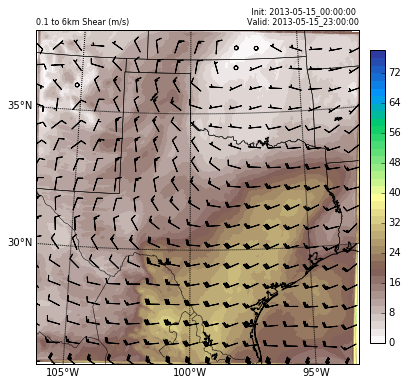

In [143]:
wrfob.plot_shear(0.1,6,time=23)

In [ ]:
wrfob.plot_surface(time=0)